In [1]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from termcolor import colored
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")

# Import des données

In [2]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [3]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [4]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [5]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [6]:
var_to_categorize = [
    "FL_REL_NON_ANNULE",
    "FL_ETR",
    "CD_ETAT_CIVIL",
    "CD_DNE_CHR_LGD_SAIN",
    "fl_prise_de_gar",
    "fl_fam_vam",
    "fam_ETH",
    "fam_ENQ",
    "fam_exp",
    "fam_hyp",
    "fam_sim",
    "fam_AEP",
    "dat_dec_echec",
    "solution",
    "fam_PCD",
    "CD_MTF_ENE_CTX",
    "niv_gravite_mtf_dne",
    "niv_gravite_mtf_dfs",
    "no_pass_def",
    "fl_def_ss_pass_CTX",
    "fl_prt_Conso",
    "fl_fonc",
    "AMI",
    "EXE",
    "PTG"
]
for var in var_to_categorize : 
    df[var] = df[var].astype("object")

In [7]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Sélection de variables
## Variables catégorielles

In [8]:
var_cat_dependantes = []

for column in cols_categorielles :
    if column != 'fl_pass_DET':  
        contingency_table = pd.crosstab(df['fl_pass_DET'], df[column])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        
        if p_value > 0.05 :
            print(colored(f"On conserve H0, {column} et fl_pass_DET sont indépendantes : p-value = {p_value}", 'red'))
        if p_value < 0.05 :
            print(colored(f"On rejette H0, {column} et fl_pass_DET ne sont pas indépendantes : p-value = {p_value}", 'green'))
            var_cat_dependantes.append(column)

On rejette H0, CD_NAT_EMP1 et fl_pass_DET ne sont pas indépendantes : p-value = 1.870335750273674e-07
On conserve H0, CD_NAT_EMP2 et fl_pass_DET sont indépendantes : p-value = 0.24967727792342584
On rejette H0, CD_DEST_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 5.15770186532289e-08
On rejette H0, CD_NATUR_OP_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 1.2735832312559122e-07
On rejette H0, FL_REL_NON_ANNULE et fl_pass_DET ne sont pas indépendantes : p-value = 1.3259092864375457e-21
On rejette H0, FL_ETR et fl_pass_DET ne sont pas indépendantes : p-value = 3.2505024549909053e-09
On rejette H0, CD_ETAT_CIVIL et fl_pass_DET ne sont pas indépendantes : p-value = 3.0139965131717664e-42
On rejette H0, CD_CSP_EMP1 et fl_pass_DET ne sont pas indépendantes : p-value = 7.911620353730646e-10
On rejette H0, CD_CSP_EMP2 et fl_pass_DET ne sont pas indépendantes : p-value = 5.376405049377136e-22
On rejette H0, CD_SITFAM_EMP1 et fl_pass_DET ne sont pas indépendantes : p-value

## Variables numériques

In [9]:
var_num_dependantes = []
for column in cols_numeriques:
    if column != 'fl_pass_DET':
        groupe_0 = [df[column][i] for i in range(len(df['fl_pass_DET'])) if df['fl_pass_DET'][i] == 0]
        groupe_1 = [df[column][i] for i in range(len(df['fl_pass_DET'])) if df['fl_pass_DET'][i] == 1]
        
        statistique_U, p_value = stats.mannwhitneyu(groupe_0, groupe_1)
        
        if p_value > 0.05 :
            print(colored(f"On conserve H0, {column} et fl_pass_DET sont indépendantes : p-value = {p_value}", 'red'))
        if p_value < 0.05 :
            print(colored(f"On rejette H0, {column} et fl_pass_DET ne sont pas indépendantes : p-value = {p_value}", 'green'))
            var_num_dependantes.append(column)

On rejette H0, nb_prt et fl_pass_DET ne sont pas indépendantes : p-value = 0.008283787616520244
On conserve H0, ANC_BANC_MAX_PFI et fl_pass_DET sont indépendantes : p-value = 0.1625046097676125
On rejette H0, MT_PATRIM_MOB et fl_pass_DET ne sont pas indépendantes : p-value = 0.03659359755211682
On rejette H0, MT_CHA_HORS_OPE_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 2.663974217584042e-21
On rejette H0, NB_CHARGE_HORS_OPE_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 5.418791187684453e-12
On rejette H0, MT_PATRIM_NET et fl_pass_DET ne sont pas indépendantes : p-value = 7.836269192258475e-28
On rejette H0, MT_REV_PFI et fl_pass_DET ne sont pas indépendantes : p-value = 7.459575252120688e-36
On conserve H0, NB_DUR_PFI et fl_pass_DET sont indépendantes : p-value = 0.11097659139885631
On conserve H0, TX_APPOR et fl_pass_DET sont indépendantes : p-value = 0.8625345536124558
On conserve H0, MT_CHA_CSM_REV et fl_pass_DET sont indépendantes : p-value = 0.13344303106340

In [10]:
var_num_dependantes.extend(var_cat_dependantes)

In [11]:
selected_features = var_num_dependantes.copy()

In [12]:
selected_features.extend(["fl_pass_DET", "cd_op", 'arrete', 'date_entree_defaut'])

In [13]:
len(selected_features)

62

In [14]:
df = df[selected_features]

In [15]:
df

,nb_prt,MT_PATRIM_MOB,MT_CHA_HORS_OPE_PFI,NB_CHARGE_HORS_OPE_PFI,MT_PATRIM_NET,MT_REV_PFI,MT_CHA_IMP,MT_CHA_PIP,MT_CHA_PIV,NB_RP_HOP,...,niv_gravite_mtf_dfs,no_pass_def,fl_def_ss_pass_CTX,regroup_natur_op,AMI,PTG,fl_pass_DET,cd_op,arrete,date_entree_defaut
0,1,0.0,0.000000,0.000000,0.000000,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,2.0,1,0,3_travaux,1.0,0.0,0,I860708600,2017-01-31,2017-01-16
1,1,0.0,0.000000,0.000000,0.000000,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,2.0,1,0,3_travaux,1.0,0.0,0,I860708600,2017-02-28,2017-01-16
2,1,0.0,0.000000,0.000000,0.000000,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,2.0,1,0,3_travaux,1.0,0.0,0,I860708600,2017-03-31,2017-01-16
3,1,0.0,0.000000,0.000000,0.000000,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,2.0,1,0,3_travaux,1.0,0.0,0,I860708600,2017-04-30,2017-01-16
4,1,0.0,0.000000,0.000000,0.000000,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,2.0,1,0,3_travaux,1.0,0.0,0,I860708600,2017-05-31,2017-01-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329059,1,29335.0,4068.000000,1.000000,250000.000000,38846.000000,0.000000,4068.000000,0.000000,1.000000,...,1.0,1,1,4_autre,1.0,0.0,0,M220505830,2022-11-30,2022-06-16
329060,1,29335.0,4068.000000,1.000000,250000.000000,38846.000000,0.000000,4068.000000,0.000000,1.000000,...,1.0,1,1,4_autre,1.0,0.0,0,M220505830,2022-12-31,2022-06-16
329061,1,11219.0,12409.744085,1.668266,175328.725006,58152.000000,2499.487335,11387.051052,376.075731,0.686054,...,1.0,1,0,4_autre,1.0,0.0,0,M220606878,2022-11-30,2022-11-04
329062,1,11219.0,12409.744085,1.668266,175328.725006,58152.000000,2499.487335,11387.051052,376.075731,0.686054,...,1.0,1,0,4_autre,1.0,0.0,0,M220606878,2022-12-31,2022-11-04


# Encodage

In [16]:
def encode_columns(df):
    encoders = {}
    for column in var_cat_dependantes:
        unique_values = df[column].nunique()
        if unique_values <= 2:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False, drop='first')
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0][1:]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(df)

In [17]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]

# Préparation des données

In [18]:
data_haz = df_train.copy()

In [19]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [20]:
data_haz['stop'] = data_haz['stop'].astype('int') / 1000000

In [21]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [22]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

In [23]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

In [24]:
data_haz.drop(columns = ["cd_op"], inplace = True)

In [25]:
data_haz2 = data_haz[['fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne','CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam','fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1','niv_gravite_mtf_dne','FL_REL_NON_ANNULE','sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR', "id", "fl_pass_DET", "start", "stop"]] 

KeyError: "['fam_ENQ', 'solution', 'FL_REL_NON_ANNULE', 'PTG', 'fl_fam_vam', 'fam_PCD', 'AMI', 'fl_def_ss_pass_CTX', 'FL_ETR'] not in index"

# Modélisation

In [69]:
data_haz

,nb_prt,MT_PATRIM_MOB,MT_CHA_HORS_OPE_PFI,NB_CHARGE_HORS_OPE_PFI,MT_PATRIM_NET,MT_REV_PFI,MT_CHA_IMP,MT_CHA_PIP,MT_CHA_PIV,NB_RP_HOP,...,fam_sim_1,dat_dec_echec_1,solution_1,fam_PCD_1,fl_def_ss_pass_CTX_1,AMI_1.0,PTG_1.0,start,stop,id
0,1,0.0,0.0,0.0,0.000000e+00,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,15.0,860708600
1,1,0.0,0.0,0.0,0.000000e+00,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,43.0,860708600
2,1,0.0,0.0,0.0,0.000000e+00,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,74.0,860708600
3,1,0.0,0.0,0.0,0.000000e+00,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,104.0,860708600
4,1,0.0,0.0,0.0,0.000000e+00,79473.199175,2499.487335,11387.051052,376.075731,0.686054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,135.0,860708600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327989,1,150047.0,40006.0,1.0,1.753287e+05,589217.000000,0.000000,40006.000000,0.000000,0.686054,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,9.0,200618962
327990,1,150047.0,40006.0,1.0,1.753287e+05,589217.000000,0.000000,40006.000000,0.000000,0.686054,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,39.0,200618962
328215,1,82675.0,47784.0,2.0,1.731857e+06,282948.000000,0.000000,47784.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,11.0,200807648
328216,1,82675.0,47784.0,2.0,1.731857e+06,282948.000000,0.000000,47784.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,42.0,200807648


In [70]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(data_haz2, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 8.41e-01, step_size = 0.9500, log_lik = -55589.29814, newton_decrement = 1.30e+04, seconds_since_start = 47.8
Iteration 2: norm_delta = 2.57e+01, step_size = 0.9500, log_lik = -374702.44344, newton_decrement = 8.11e+06, seconds_since_start = 95.6
Iteration 3: norm_delta = 2.50e+00, step_size = 0.0950, log_lik = -7731975.02109, newton_decrement = 7.71e+06, seconds_since_start = 144.9
Iteration 4: norm_delta = 2.88e+00, step_size = 0.1210, log_lik = -6335881.54641, newton_decrement = 6.32e+06, seconds_since_start = 194.5
Iteration 5: norm_delta = 3.23e+00, step_size = 0.1542, log_lik = -4899626.67791, newton_decrement = 4.88e+06, seconds_since_start = 242.5
Iteration 6: norm_delta = 3.48e+00, step_size = 0.1964, log_lik = -3511617.41256, newton_decrement = 3.49e+06, seconds_since_start = 291.4
Iteration 7: norm_delta = 3.56e+00, step_size = 0.2503, log_lik = -2276364.49353, newton_decrement = 2.25e+06, seconds_since_start = 340.2
Iteration 8: norm_delta = 3.39e+

<lifelines.CoxTimeVaryingFitter: fitted with 221971 periods, 17815 subjects, 5006 events>

In [77]:
results = ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 221971 periods, 17815 subjects, 5006 events>
         event col = 'fl_pass_DET'
         penalizer = 0.1
number of subjects = 17815
 number of periods = 221971
  number of events = 5006
partial log-likelihood = -245539.09
  time fit was run = 2024-01-07 13:11:40 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
nb_prt                   0.02       1.02       0.01            -0.01             0.04                 0.99                 1.04
MT_PATRIM_MOB           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_CHA_HORS_OPE_PFI     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
NB_CHARGE_HORS_OPE_PFI  -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
MT_PATRIM_NET           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_REV_PFI              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHA_IMP              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHA_PIP              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHA_PIV              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
NB_RP_HOP               -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
NB_RS_HOP                0.03       1.03       0.02            -0.02             0.07                 0.98                 1.07
cum_dec                  0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
cum_rec                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
cum_frs_externes        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_EAD_RESID            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MR_arr                   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
dls_mep_entree_def       0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
nb_bienHOP              -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
ANC_PRO_MAX_PFI         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
max_age_ctx              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
nb_empr_ope              0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
mt_dec_cum_IMP_tot      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHG_MSL              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mt_rev_dispo            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
dls_ges_def             -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98
AGE_EMP2                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_REST_VIVRE           -0.00       1.00       0.00            -0.00            -0.00              

In [78]:
results

<Axes: xlabel='log(HR) (95% CI)'>

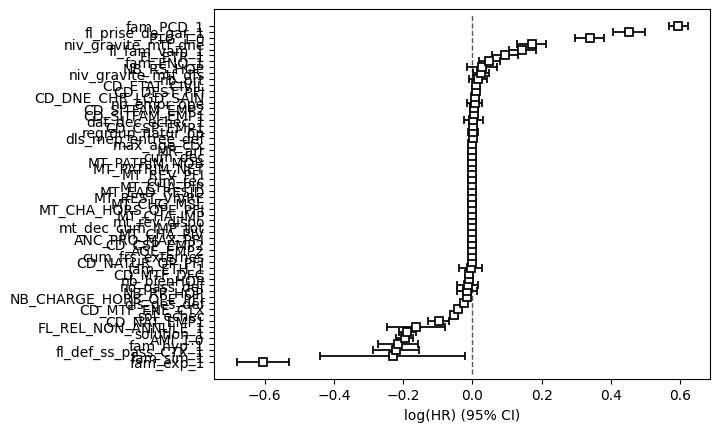

In [72]:
ctv.plot()